## Import PyTorch and set up device agnostic code

In [1]:
import torch
from torch import nn

# GET DATA
import requests
import zipfile
from pathlib import Path

# DATA PREP
import os

# VISUALIZE IMAGE
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# TRANSFORMING DATA
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision

# custom dataset
from torch.utils.data import Dataset
from typing import Tuple, Dict, List

# TRAINING LOOP
from tqdm.auto import tqdm
from timeit import default_timer as timer



In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 1.0 Get Data

Our dataset is a subset of the Food101 dataser.

Food101 starts 101 different classes of food and 1000 imges per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images (75 training, 25 testing).

Why do this?

WHen starting our ML projects, it's important to try things on a small scale and then increase the scale when necessary. The whole point is to speed up how fast you can experiment.

In [3]:
# set up data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# if the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f'{image_path} directory already exists..... skipping download')
else:
    print(f'{image_path} does not exist, creating one....')
    image_path.mkdir(parents=True, exist_ok=True)

# download pizza, steak, sushi data
with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
    r = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    print('Downloading pizza, steak and sushi data...')
    f.write(r.content)

# unzip pizza, steak, ssushi data
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('Unzipping pizza, steak and sushi data...')
    zip_ref.extractall(image_path)


data/pizza_steak_sushi does not exist, creating one....
Unzipping pizza, steak and sushi data...


## 2.0 Becoming one with the data (data preparation and exploration)

In [4]:
def walk_though_dir(dir_path):
    """Walks through dir_path, returning its content in tree format"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [5]:
walk_though_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'


In [6]:
# set up train and test paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

Let's write code to:
1. Get all of the image paths
2. Pick a random image path using ppython's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we are working with images, let's open the iage with PIL
5. We'll then show the image and print metadata

In [7]:
image_path

PosixPath('data/pizza_steak_sushi')

In [8]:
# set seed
random.seed(42)

# 1. Get all the image paths
img_path_list = list(image_path.glob('*/*/*.jpg'))

# 2. Pick a random image path
rand_img_path = random.choice(img_path_list)

# 3. Get the image class from path name (i.e name of img directory where img is stored)
img_class = rand_img_path.parent.stem

# 4. Open image
img = Image.open(rand_img_path)

# 5. Print metadata
print(f'Random image path: {rand_img_path}')
print(f'Image class: {img_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')

Random image path: data/pizza_steak_sushi/test/sushi/1245193.jpg
Image class: sushi
Image height: 295
Image width: 512


In [9]:
print(img)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x295 at 0x79039AA14130>


(-0.5, 511.5, 294.5, -0.5)

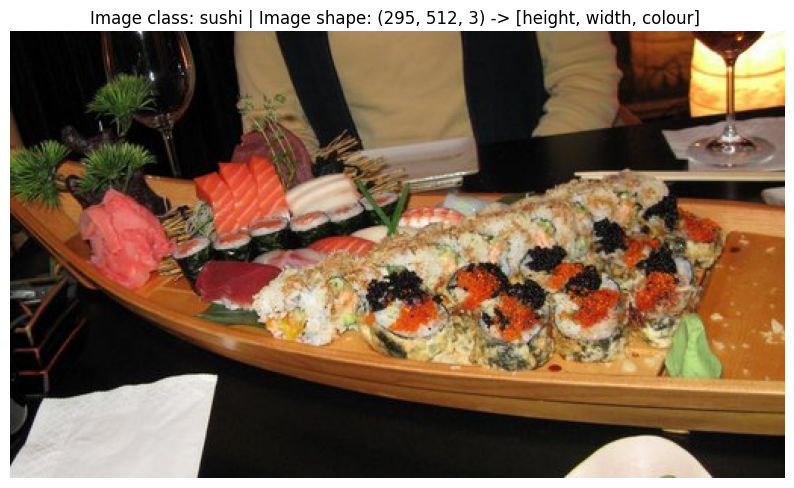

In [10]:
# visualize with matplotlib

# turn the image into an array
img_as_array = np.asarray(img)

# plot the image
plt.figure(figsize=(10, 8))
plt.imshow(img_as_array)
plt.title(f'Image class: {img_class} | Image shape: {img_as_array.shape} -> [height, width, colour] ')
plt.axis(False)

## 3.0 Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (i.e here, juat a numerical representation of the images).
2. Turn it into a `torch.utils.Dataset` and subsequently a `torch.utils.DataLoader`, we'll call these `Dataset` and `DataLoader`.

### 3.1 Transforming data with `torchvision.transforms`

In [11]:
# write a transform for image
data_transform = transforms.Compose([
    # resize the images to 64x64
    transforms.Resize(size=(64, 64)),

    # flip the images randomly on horizontal
    transforms.RandomHorizontalFlip(p=0.5), # means 50% of the time, if an image goes throght the tansform pipeline, it will get flipped on the horizonatl axis

    # turn the image into a torch.tensor
    transforms.ToTensor()
])

In [12]:
# pass in PIL image
data_transform(img).shape

torch.Size([3, 64, 64])

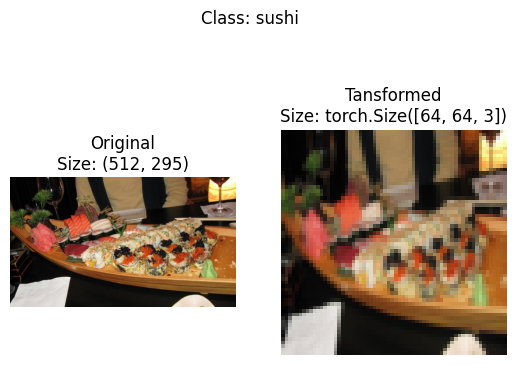

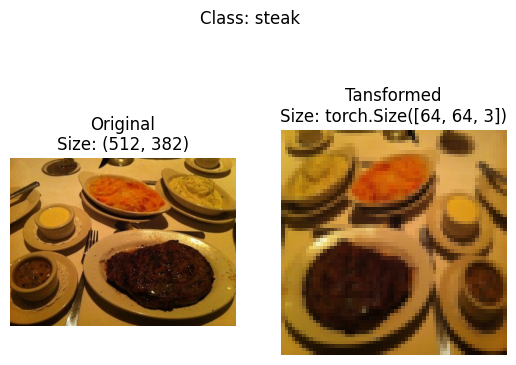

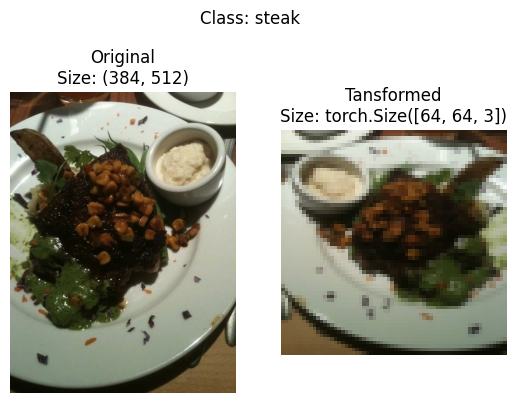

In [13]:
def plot_transformed_images(img_paths, transform, n=3, seed=None):
    """
    Selects random images from a path of imagesand loads/tansforms
    them thenplot the original vs thetransformed version
    """
    if seed:
        random.seed(seed)

    rand_img_paths = random.sample(img_paths, k=n)
    for img_path in rand_img_paths:
        with Image.open(img_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f'Original\nSize: {f.size}')
            ax[0].axis(False)

            # trnasform and plot target img
            transformed_img = transform(f).permute(1, 2, 0) # note we need to change the shape for matplot lib i.e go from (3, 64, 64) -> (64, 64, 3)
            ax[1].imshow(transformed_img)
            ax[1].set_title(f'Tansformed\nSize: {transformed_img.shape}')
            ax[1].axis(False)

            fig.suptitle(f'Class: {img_path.parent.stem}')

plot_transformed_images(img_paths=img_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

## 4.0 Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [14]:
# use image folder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
# get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
# check length of dataset
len(train_data), len(test_data)

(225, 75)

In [18]:
targets = train_data.targets
samples = train_data.samples
len(targets), len(samples)

(225, 225)

In [19]:
# index on the train data dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image type: {img.dtype}")
print(f"Image label: {label}")
print(f"Label data type: {type(label)}")

class_names[label]

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

'pizza'

In [20]:
# Rearrange the order dimensions
img_permute = img.permute(1,2,0)

# print out diff shapes
print(f'Original shape: {img.shape} -> [colour channels, height, width]')
print(f'Image permute : {img_permute.shape} -> [height, width, colour channels]')

Original shape: torch.Size([3, 64, 64]) -> [colour channels, height, width]
Image permute : torch.Size([64, 64, 3]) -> [height, width, colour channels]


### 4.1 Turn loaded images into `DataLoader`'s

A `DataLoader` is going to help us turn our `Dataset`'s inot iterables and we can customize the `batch_size` so our model can see `batch_size` images at a time


In [21]:
import os
os.cpu_count()

2

In [22]:
# turn train and test datasets into DataLoader's'

BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(), # the more the better
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count()
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x790399753490>,
 <torch.utils.data.dataloader.DataLoader at 0x790399751690>)

In [23]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [24]:
len(train_data), len(test_data) # i.e length of data/32 = lenth of dataloader

(225, 75)

In [25]:
images, labels = next(iter(train_dataloader))

print(f'Image shape: {images.shape} -> [batch_size, color_channels, height, width]')
print(f'Label shape: {labels.shape} -> [batch_size]')
# len(img[0])

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32]) -> [batch_size]


## 5.0 Option 2: Loading Image Data with a custom `Dataset`

1. Want to be able to load images from file.
2. Want to be able to get class names from Dataset.
3. Want to be able to get classes as dicionary from the datasets.

Pros:
* Can create a `Dataset` out of almost anything
* You are not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in writing more code, which could be


In [26]:
# instance of torchvision .datasets.ImageFolder
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).

2. Raise an error if the classnames aren't found (if this happens, there might be something wrong with the directory structure).

3. Turn the class names into a dict and a list and return them.

In [27]:
# setup path for target directory
targ_dir = train_dir
print(f"Target dir: {targ_dir}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(targ_dir))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [28]:
def find_classes(directory: str) -> Tuple[list[str], Dict[str, int]]:
    """Finds the class folder names in a target directory."""
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

    # create a dictionary of index labels
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [29]:
find_classes(targ_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2  Craete a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:
1. Subclass `torch.uils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
    * paths - paths of our images
    * transform - the transform we'd like to use
    * classes - a list of the target classes
    * class_to_idx - a dict of the target classes mapped to integer labels

4. Create a function to `load_images`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index









In [30]:
# write a custom dataset

# 1. subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize our custom dataset
    def __init__(self, target_directory: str, transform=None):
        super().__init__()
        # 3. Create class atrributes
        self.paths = list(Path(target_directory).glob('*/*.jpg')) # -> e.g if targ dir is test, we are accssing [pizz|sushi|steak]/1.jpg
        # setup transforms
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(target_directory)

    # 4. Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        """
        Opens an image via a path and returns it.
        """
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite __len()__
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    # 6. Overwrite __getitem()__ method to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)"
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects path in the format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        # if tansform set
        if self.transform:
            return self.transform(img), class_idx # return data, label
        else:
            return img, class_idx # return data, label (X, y)


In [31]:
# create a transform
train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [32]:
# test out ImageFolderCustom
train_data_custom = ImageFolderCustom(target_directory=train_dir,
                                      transform=train_transform)

test_data_custom = ImageFolderCustom(target_directory=test_dir,
                                      transform=test_transform)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x79039977da50>,
 <__main__.ImageFolderCustom at 0x79039977df90>)

In [33]:
len(train_data), len(test_data_custom)

(225, 75)

In [34]:
len(test_data), len(test_data_custom)

(75, 75)

In [35]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [36]:
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indices from the target dataset.
5. Setup a matplotlib plot.
6. loop through the random sample images and plot them with matplotlib.
7. Make sure the dimensions of our images line up with matplot lib (HWC -> [height, width, color_channel])


In [37]:
# 1. create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                         classes: List[str] = None,
                         n: int=10,
                         display_shape: bool = True,
                         seed: int = None):
    # 2. Adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display, purposes, n shouldn't be larger than 10, setting to 10.")

    # 3. set the seed
    if seed:
        random.seed(seed)

    # 4. get random sample indice
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through random indexes and plot them with matplotlib
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust tensor dims for plotting
        targ_img_permute = targ_image.permute(1, 2, 0)

        # plot adjusted samples
        plt.subplot(1, n, i + 1)
        plt.imshow(targ_img_permute)
        plt.axis(False)
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f'\nshape: {targ_img_permute.shape}'
        plt.title(title)



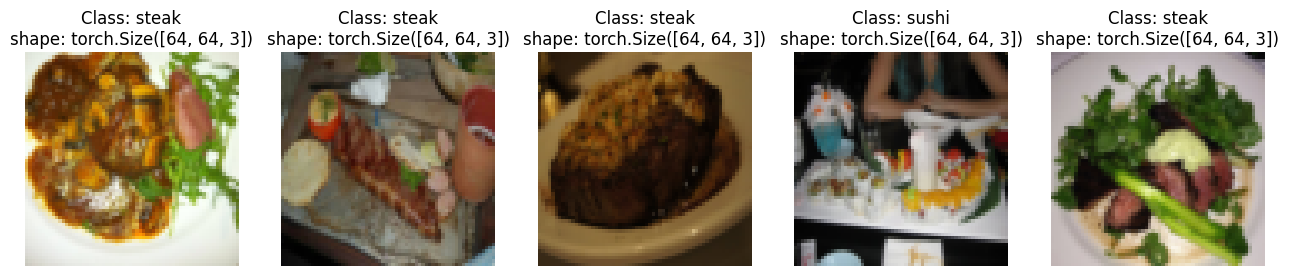

In [38]:
# display random images from Image folder

display_random_images(dataset=train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=None)

### 5.4 Turn custom loaded images into `Dataloader`s

In [39]:
# make data loaders for custom data

NUM_WORKERS = os.cpu_count()

train_dataloader_custom = DataLoader(
    dataset=train_data_custom,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)

test_dataloader_custom = DataLoader(
    dataset=test_data_custom,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7903997cb940>,
 <torch.utils.data.dataloader.DataLoader at 0x790396465a20>)

In [40]:
len(train_dataloader_custom), len(test_dataloader_custom)

(8, 3)

In [41]:
img, label = next(iter(train_dataloader_custom))

print(f'Image shape is: {img.shape}')
print(f'label shape is: {label.shape}')

Image shape is: torch.Size([32, 3, 64, 64])
label shape is: torch.Size([32])


## 6.0 Other forms of transforms(data augmentation)

Data augmentation is the process of artifically adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...



In [42]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), #selects a transform randomly and use random parameters on that transform to change an image
    transforms.ToTensor()
])

In [43]:
image_path_list = list(Path(test_dir).glob('*/*.jpg'))
image_path_list

[PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/966174.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3873283.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1627703.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/100274.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1302563.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1882831.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/354513.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2144308.jpg'),
 PosixPath('data/pizza_steak_sushi

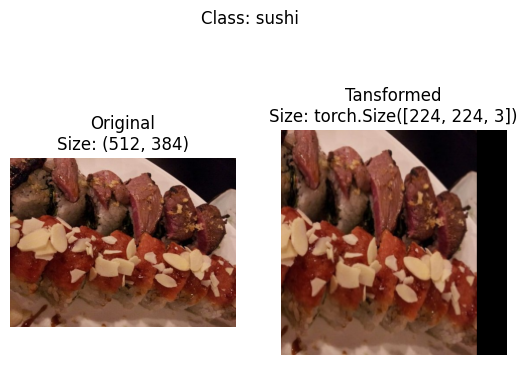

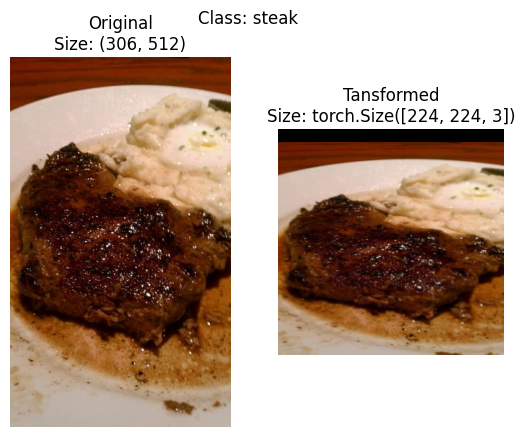

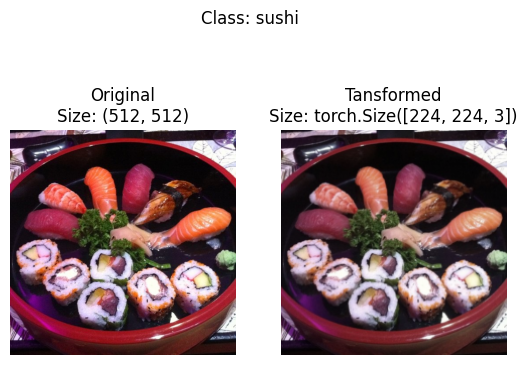

In [44]:
# plot random transformed images
plot_transformed_images(
    img_paths=image_path_list,
    transform=train_transform,
    n=3
)

## 7.0 Model 0: TinyVGG without data augmentation

Let's replicate TinyVGG architecture from the cnn explainer website

### 7.1 Creating transforms and loading data for model 0

In [45]:
# Create a simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [46]:
# load data
train_data = datasets.ImageFolder(
    root=train_dir,
    transform=simple_transform,
)

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=simple_transform
)

# print(f'Tran data: {train_data}\n\n\nTest data: {test_data}')
# print(f'Tran data length: {len(train_data)}\nTest data length: {len(test_data)}')

# MAKE DATA LOADERS
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

# print(f'Train dataloader: {train_dataloader}\n\n\nTest dataloader: {test_dataloader}')
# print(f'Tran dataloader length: {len(train_dataloader)}\nTest dataloader length: {len(test_dataloader)}')
class_names = train_data.classes
# class_names, test_data.targets

### 7.2 Create TinyVGG model class

In [47]:
class TinyVGGV0(nn.Module):
    """
    Model architecture copying TinyVGG from CNN Explainer
    """
    def __init__(self, input_features, hidden_units, output_features):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_features,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=4
                      ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=4
                      ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=4
                      ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=4
                      ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=4
                      ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=4
                      ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=4
                      ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=4
                      ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 15 * 15,
                      out_features=output_features)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # print(f'The shape of x after conv_block_1: {x.shape}')
        x = self.conv_block_2(x)
        # print(f'The shape of x after conv_block_2: {x.shape}')
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        # print(f'The shape of x after conv_block_2: {x.shape}')
        x = self.classifier(x)
        return x #self.classifier(self.conv_block_3(self.conv_block_2(self.conv_block_1(x))))


model_0 = TinyVGGV0(input_features=3,
                    hidden_units=10,
                    output_features=len(class_names)).to(device)

### 7.3 Try a dummy forward pass to get dimensions for inear layer in model

In [48]:
dummy_t = torch.randn(size=(3, 64, 64))

dummy_output = model_0(dummy_t.unsqueeze(0).to(device))

### 7.4 Use `torchinfo` to get an idea of the shapes going through iur model

In [49]:
%pip install torchinfo

In [50]:
from torchinfo import summary

summary(model_0, input_size=(BATCH_SIZE, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGGV0                                [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 38, 38]          --
│    └─Conv2d: 2-1                       [32, 10, 70, 70]          280
│    └─ReLU: 2-2                         [32, 10, 70, 70]          --
│    └─Conv2d: 2-3                       [32, 10, 76, 76]          910
│    └─ReLU: 2-4                         [32, 10, 76, 76]          --
│    └─MaxPool2d: 2-5                    [32, 10, 38, 38]          --
├─Sequential: 1-2                        [32, 10, 25, 25]          --
│    └─Conv2d: 2-6                       [32, 10, 44, 44]          910
│    └─ReLU: 2-7                         [32, 10, 44, 44]          --
│    └─Conv2d: 2-8                       [32, 10, 50, 50]          910
│    └─ReLU: 2-9                         [32, 10, 50, 50]          --
│    └─MaxPool2d: 2-10                   [32, 10, 25, 25]          --
├─Sequentia

### 7.5 Ceate train and test loop functions

* `train_step()` - takes in a model and data loader and trains the model on the data loader.
* `test_step()` - takes in a model and data loader and evaluates the model on the data loader

In [51]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               device: torch.device,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()
    total_loss, total_acc = 0, 0
    for batch_num, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_logits = model(X)

        loss = loss_fn(y_logits, y)
        total_loss += loss.item()
        y_pred_class = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
        total_acc += (y_pred_class == y).sum().item() / len(y_logits)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    # calc avg loss and accuracy per batch and print out whats happening
    total_loss /= len(data_loader)
    total_acc /= len(data_loader)
    # print(f'Train loss: {total_loss:.5f} | Train accuracy: {total_acc * 100:.2f}%')
    return total_loss, total_acc


def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               device: torch.device,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.inference_mode():
        for batch_num, (X, y) in enumerate(data_loader):
            X, y = X.to(device), y.to(device)
            y_logits = model(X)

            total_loss += loss_fn(y_logits, y).item()
            y_pred_class = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
            total_acc += (y_pred_class == y).sum().item() / len(y_logits)

        # calc loss and accuracy and print out whats happening
        total_loss /= len(data_loader)
        total_acc /= len(data_loader)
        # print(f'Test loss: {total_loss:.5f} | Test accuracy: {total_acc * 100:.2f}%')
    return total_loss, total_acc

def print_train_time(start, end, device):
    pass

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [52]:
def train(model, device, loss_fn, optimizer,train_dataloader, test_dataloader, epochs=5):
    # create empty results dictionary
    results = {'train_loss': [],
                   'train_acc': [],
                   'test_loss': [],
                   'test_acc': [],
                   }

    for epoch in tqdm(range(epochs)):

        train_loss, train_acc = train_step(model=model,
                data_loader=train_dataloader,
                device=device,
                loss_fn=loss_fn,
                optimizer=optimizer)

        test_loss, test_acc = test_step(model=model,
                data_loader=test_dataloader,
                device=device,
                loss_fn=loss_fn,
                optimizer=optimizer)

        # print out what's happening
        print(f'Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f} ')

        # update results dictionary
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)

        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    return results


### 7.7 Train and evaluate model_0

In [53]:
torch.manual_seed(42)

NUM_EPOCHS = 20

# model
model_0 = TinyVGGV0(input_features=3,
                    hidden_units=10,
                    output_features=len(class_names)).to(device)

# loss
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.01)


train_time_start_model_0 = timer()
# train model
model_0_results = train(epochs=NUM_EPOCHS,
                        model=model_0,
                        device=device,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader)
train_time_end_model_0 = timer()
print(f'Total training time: {train_time_end_model_0 - train_time_start_model_0:.2f}')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1685 | Train acc: 0.2812 | Test loss: 1.1199 | Test acc: 0.2604 
Epoch: 1 | Train loss: 1.1031 | Train acc: 0.2891 | Test loss: 1.0914 | Test acc: 0.5417 
Epoch: 2 | Train loss: 1.1000 | Train acc: 0.2812 | Test loss: 1.0954 | Test acc: 0.5417 
Epoch: 3 | Train loss: 1.0992 | Train acc: 0.3086 | Test loss: 1.0991 | Test acc: 0.2604 
Epoch: 4 | Train loss: 1.1010 | Train acc: 0.3047 | Test loss: 1.0971 | Test acc: 0.2604 
Epoch: 5 | Train loss: 1.0990 | Train acc: 0.3047 | Test loss: 1.1003 | Test acc: 0.2604 
Epoch: 6 | Train loss: 1.1000 | Train acc: 0.2734 | Test loss: 1.1069 | Test acc: 0.1979 
Epoch: 7 | Train loss: 1.0962 | Train acc: 0.4141 | Test loss: 1.1133 | Test acc: 0.1979 
Epoch: 8 | Train loss: 1.0937 | Train acc: 0.4141 | Test loss: 1.1201 | Test acc: 0.1979 
Epoch: 9 | Train loss: 1.0978 | Train acc: 0.2930 | Test loss: 1.1255 | Test acc: 0.1979 
Epoch: 10 | Train loss: 1.0961 | Train acc: 0.2930 | Test loss: 1.1282 | Test acc: 0.1979 
Epoch: 11

### 7.8 Plot the loss curves of model 0

A loss curve is a way of tracking your model's progress over time

In [54]:
# get the mode_0 result keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [55]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """ Plots training curves of a results dictionary"""
    # get the loss values of the results dict
    loss = results['train_loss']
    test_loss = results['test_loss']

    # get the accuracy values of the results dict
    acc = results['train_acc']
    test_acc = results['test_acc']

    # figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # setup a plot
    plt.figure(figsize=(15, 7))

    # plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')

    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, label='train_acc')
    plt.plot(epochs, test_acc, label='test_acc')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()


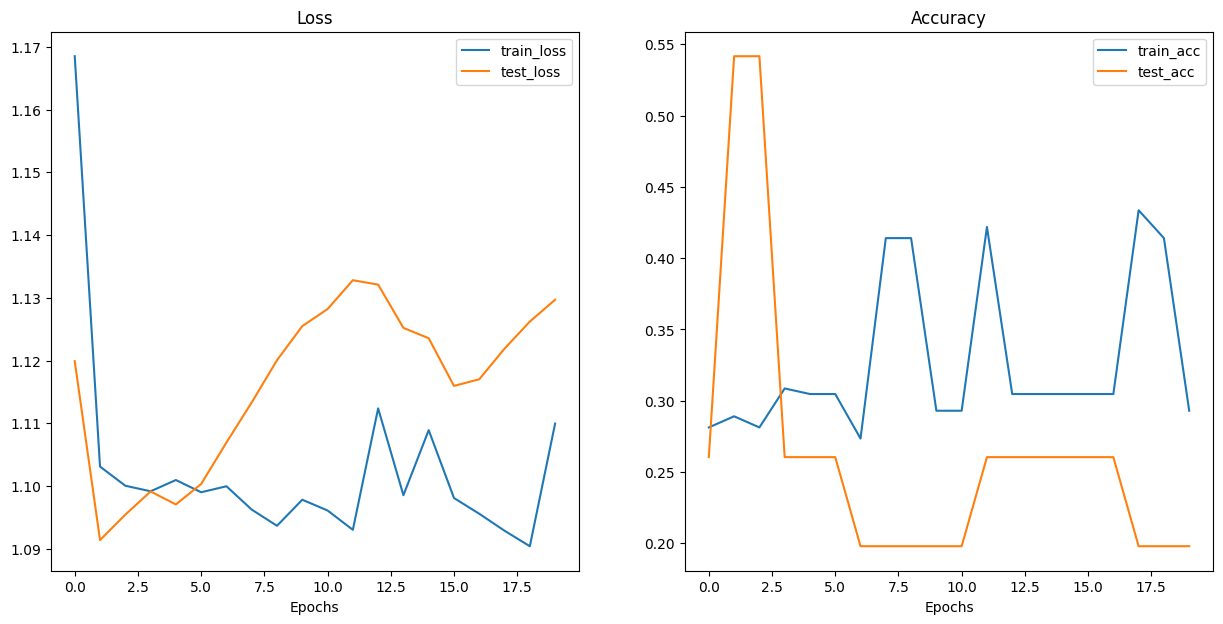

In [56]:
plot_loss_curves(model_0_results)

## 8.0 What should an ideal loss curve look like?

A loss curve is one of the moset helpful ways to troubleshoot a model.

## 9.0 Model 1: TinyVGG with Data Augmentation

### 9.1 Create transform with data augmentation

In [57]:
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

### 9.2 Create train and test datasets and dataloaders with data augmentation

In [58]:
torch.manual_seed(42)

# DATA SETS
train_data_aug = datasets.ImageFolder(
    root=train_dir,
    transform=train_transform_trivial
)

test_data_aug = datasets.ImageFolder(
    root=test_dir,
    transform=test_transform_trivial
)
print(f'Length of train data: {len(train_data_aug)} | Length of test data: {len(test_data_aug)}')

# DATALOADERS
train_dataloader_aug = DataLoader(
    dataset=train_data_aug,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)

test_dataloader_aug = DataLoader(
    dataset=test_data_aug,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

print(f'Length of train data loader: {len(train_dataloader_aug)} | Length of test data loader: {len(test_dataloader_aug)}')


Length of train data: 225 | Length of test data: 75
Length of train data loader: 8 | Length of test data loader: 3


### 9.3 Construct and train model 1

This time we'll using the same model architecture, but this time, we augment the data.

In [59]:


class TinyVGGV1(nn.Module):
    def __init__(self, input_features, hidden_units, output_features):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_features,
                      out_channels=hidden_units,
                      stride=1,
                      kernel_size=3,
                      ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      stride=1,
                      kernel_size=3,),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      stride=1,
                      kernel_size=3,
                      ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      stride=1,
                      kernel_size=3,),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 54* 54,
                      out_features=output_features)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # print(f'The shape of x after conv block 1: {x.shape}')
        x = self.conv_block_2(x)
        # print(f'The shape of x after conv block 2: {x.shape}')
        x = self.classifier(x)
        return x


model_1_5 = TinyVGGV1(input_features=3,
                    hidden_units=10,
                    output_features=len(class_names)).to(device)

In [61]:
dummy_t = torch.randn(size=(3, 64, 64))

dummy_outs = model_1_5(dummy_t.unsqueeze(0).to(device))

In [62]:
model_1 = TinyVGGV0(input_features=3,
                    hidden_units=10,
                    output_features=len(class_names)).to(device)

# loss
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.01)


train_time_start_model_0 = timer()
# train model
model_1_results = train(epochs=NUM_EPOCHS,
                        model=model_1,
                        device=device,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        train_dataloader=train_dataloader_aug,
                        test_dataloader=test_dataloader_aug)
train_time_end_model_0 = timer()
print(f'Total training time: {train_time_end_model_0 - train_time_start_model_0:.2f}')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1761 | Train acc: 0.2734 | Test loss: 1.0544 | Test acc: 0.5417 
Epoch: 1 | Train loss: 1.1007 | Train acc: 0.2891 | Test loss: 1.1099 | Test acc: 0.1979 
Epoch: 2 | Train loss: 1.0973 | Train acc: 0.2852 | Test loss: 1.1137 | Test acc: 0.2604 
Epoch: 3 | Train loss: 1.0938 | Train acc: 0.4258 | Test loss: 1.1215 | Test acc: 0.2604 
Epoch: 4 | Train loss: 1.0957 | Train acc: 0.3047 | Test loss: 1.1280 | Test acc: 0.2604 
Epoch: 5 | Train loss: 1.1122 | Train acc: 0.3047 | Test loss: 1.1318 | Test acc: 0.2604 
Epoch: 6 | Train loss: 1.0949 | Train acc: 0.3047 | Test loss: 1.1248 | Test acc: 0.2604 
Epoch: 7 | Train loss: 1.0956 | Train acc: 0.2969 | Test loss: 1.1245 | Test acc: 0.1979 
Epoch: 8 | Train loss: 1.0936 | Train acc: 0.4141 | Test loss: 1.1254 | Test acc: 0.1979 
Epoch: 9 | Train loss: 1.0948 | Train acc: 0.2930 | Test loss: 1.1294 | Test acc: 0.1979 
Epoch: 10 | Train loss: 1.0929 | Train acc: 0.4492 | Test loss: 1.1320 | Test acc: 0.2604 
Epoch: 11

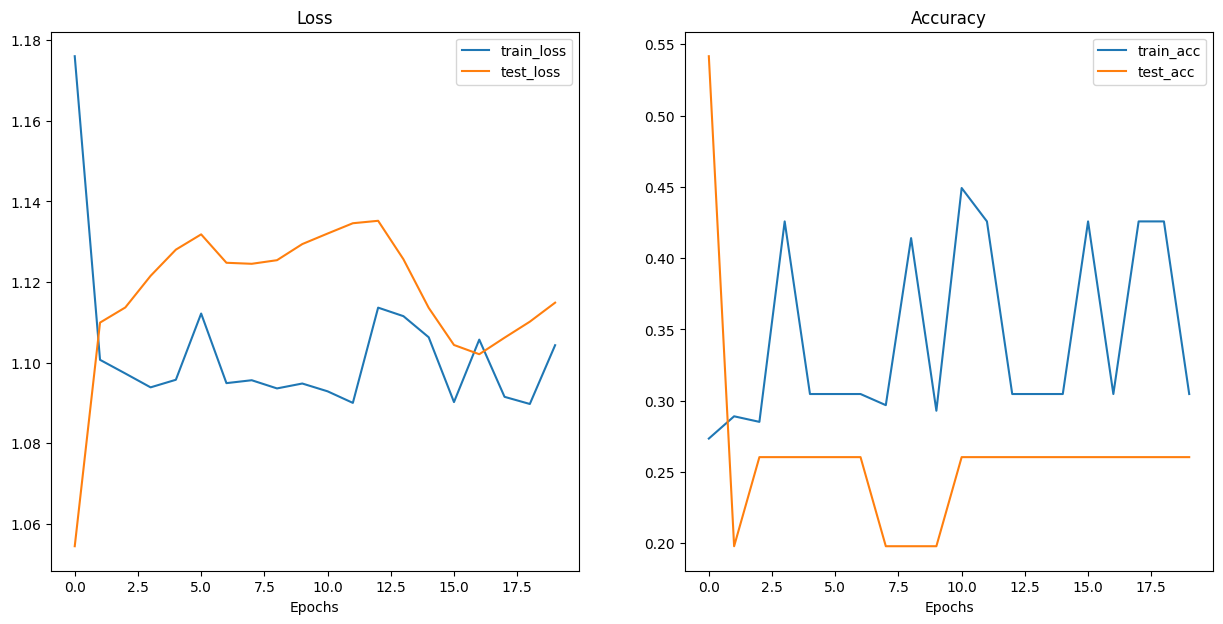

In [63]:
plot_loss_curves(model_1_results)

## 10. Compare model results

After evaluating our modelling experiments on theoi own, it is important to compare them to each other.

There's a few different ways to do this:
1. Hard coding(what we're doing)
2.PyTorch + Tensorboard - https://pytorch.org/docs/stable/tensorboard.html
3. Weights and biases - https://wandb.ai/site/experiment-tracking
4. MLFlow - https://mlflow.org/

In [64]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

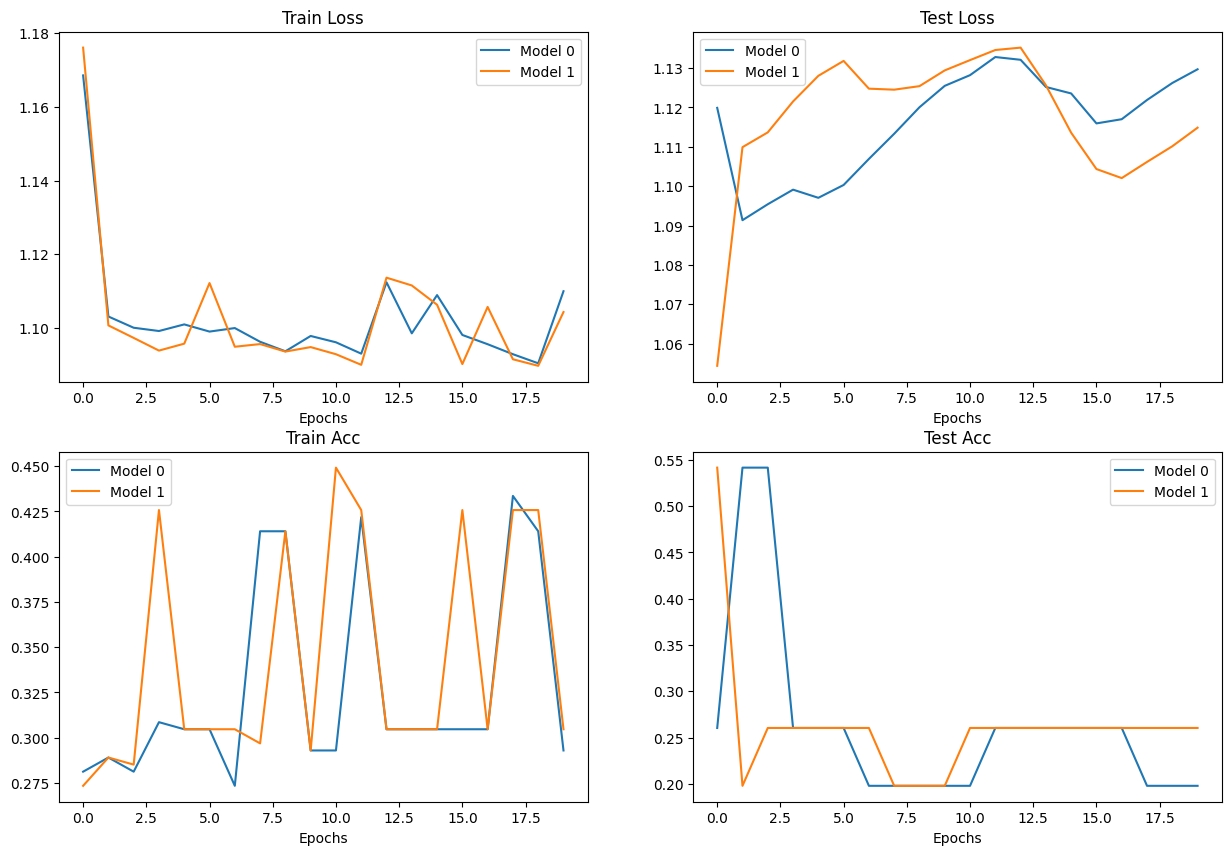

In [65]:
# setup a plot
plt.figure(figsize=(15, 10))

# get number of epochs
epochs = range(len(model_0_df))

# plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df['train_loss'], label='Model 0')
plt.plot(epochs, model_1_df['train_loss'], label='Model 1')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.legend()

# plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df['test_loss'], label='Model 0')
plt.plot(epochs, model_1_df['test_loss'], label='Model 1')
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.legend()

# plot train acc
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df['train_acc'], label='Model 0')
plt.plot(epochs, model_1_df['train_acc'], label='Model 1')
plt.title('Train Acc')
plt.xlabel('Epochs')
plt.legend()

# plot test loss
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df['test_acc'], label='Model 0')
plt.plot(epochs, model_1_df['test_acc'], label='Model 1')
plt.title('Test Acc')
plt.xlabel('Epochs')
plt.legend()

## 11. Making a prediction on a custom image

Although we've trained a model on custom data....how do you make a prediction om a sample/image tha's not either training or testing dataset

In [66]:
# download custom image
import requests

# setup custom image path
custom_image_path = data_path / '04-pizza-dada.jpeg'

# download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, 'wb') as f:
        r = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg')
        print(f'Downloading {custom_image_path}...')
        f.write(r.content)
else:
    print(f'{custom_image_path} already exists, skipping download...')



### 11.1 Loading in a custom image with PyTorch

We have to make sure our custom image is in the same format as the data our model was trained on.

* In tensor form with datatype (torch.float32)
* Of shape 64 x 64 x 3
* On the right device

In [67]:
# read custom image
custom_img_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f'Custom image:\n{custom_img_uint8}')
print(f'Custom image shape: {custom_img_uint8.shape}')
print(f'Custom image datatype: {custom_img_uint8.dtype}')


Custom image:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image datatype: to

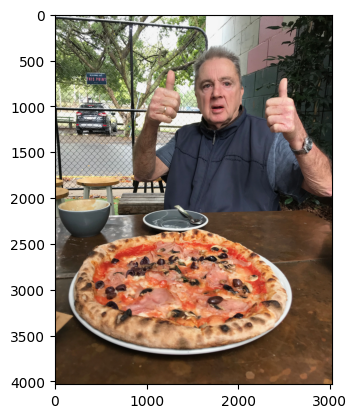

In [68]:
plt.imshow(custom_img_uint8.permute(1,2,0))

### 11.2 Making a prediction on a custom image wih a trained PyTorch model

In [69]:
# try to make prediction on uint8 format, it doesn't work
model_1.eval()
with torch.inference_mode():
    model_1(custom_img_uint8)



RuntimeError: Input type (unsigned char) and bias type (float) should be the same

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x52600 and 2250x3)

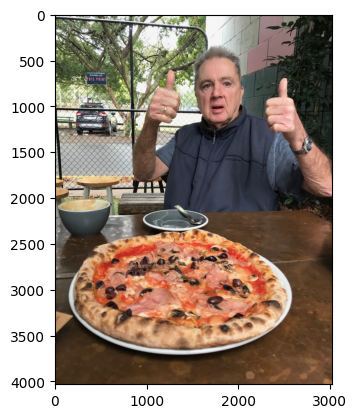

In [73]:
# so...
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255 # to scale pixel value to be between 0 and 1
plt.imshow(custom_image.permute(1,2,0))
model_1.eval()
with torch.inference_mode():
    model_1(custom_image)

In [72]:
# create transform pipeline
cust_img_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

# transformed image
custom_image_transed = cust_img_transform(custom_image)

print(f'Original shape: {custom_image.shape}')
print(f'Transformed shape: {custom_image_transed.shape}')

Original shape: torch.Size([3, 4032, 3024])
Transformed shape: torch.Size([3, 64, 64])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


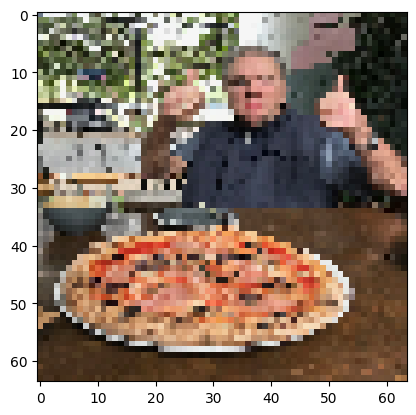

In [74]:
plt.imshow(custom_image_transed.permute(1,2,0))


In [75]:
model_1.eval()
with torch.inference_mode():
    cust_img_pred = model_1(custom_image_transed.unsqueeze(0).to(device))

In [76]:
cust_img_pred

tensor([[ 0.0841, -0.0501, -0.0698]])

Note, to make a prediction on a custom image we had to:

* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on (3x64x64) with a batchsize ...(1,3, 64, 64)
* Make sure the image was on the same device as our model


In [77]:
# convert logits -> prediction probabilities -? labels
cust_img_pred_labels = torch.argmax(torch.softmax(cust_img_pred, dim=1), dim=1)
class_names[cust_img_pred_labels]

'pizza'

### 11.3 Putting custom image prediction together: building a function

Ideal outcome:

A function where we pass and image path to and have our model predict o that image and plot the image and prediction

In [79]:
cust_img_final = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
transform_cust = transforms.Compose([
    transforms.Resize(size=(64, 64))
])
cust_img_final = transform_cust(cust_img_final)
model_1.eval()
with torch.inference_mode():
    cust_img_pred = model_1(custom_image_transed.unsqueeze(0).to(device))

cust_img_pred_labels = torch.argmax(torch.softmax(cust_img_pred, dim=1), dim=1)
class_names[cust_img_pred_labels]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


'pizza'

In [82]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
    "Makes a prediction on a target image with trained model and plots the image and prediction"
    img = torchvision.io.read_image(str(image_path)).type(torch.float32) / 255.
    if transform:
        img = transform(img)

    model.eval()
    with torch.inference_mode():
        img_pred = model(img.unsqueeze(0).to(device))

    img_pred_label = torch.argmax(torch.softmax(img_pred, dim=1), dim=1)
    class_ = class_names[img_pred_label]
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f'{class_}')
    plt.axis(False)
    plt.legend()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


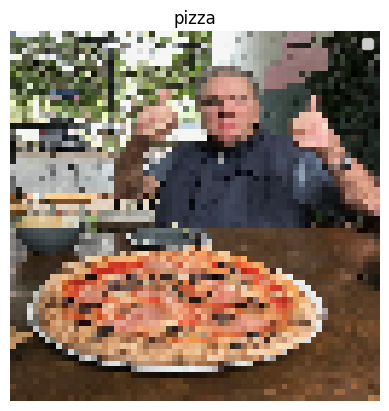

In [83]:
pred_and_plot_image(model=model_1,
                        image_path=str(custom_image_path),
                        class_names=class_names,
                        transform=cust_img_transform,
                        device=device)

## Exercises: https://colab.research.google.com/drive/1JvxHFQ57Buc-8bUlbJF93ad65WK2JB_o?hl=en